# Annotation of DA Peaks

**Created**: 27 January 2021

## Environment

In [1]:
if (!requireNamespace("ComplexHeatmap", quietly=T)) {
    BiocManager::install("ComplexHeatmap")
}

In [2]:
library(tidyverse)
library(data.table)
library(RColorBrewer)
library(ComplexHeatmap)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: grid

ComplexHeatmap version 2.6.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com

## Load Data

In [3]:
ia.homer.annot <- fread("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/immune_atlas/homer/homer_peak_annotation.txt", sep="\t")

colnames(ia.homer.annot)[1] <- "PeakID"
colnames(ia.homer.annot) <- make.names(colnames(ia.homer.annot))

In [4]:
head(ia.homer.annot)

PeakID,Chr,Start,End,Strand,Peak.Score,Focus.Ratio.Region.Size,Annotation,Detailed.Annotation,Distance.to.TSS,Nearest.PromoterID,Entrez.ID,Nearest.Unigene,Nearest.Refseq,Nearest.Ensembl,Gene.Name,Gene.Alias,Gene.Description,Gene.Type
<chr>,<chr>,<int>,<int>,<chr>,<int>,<lgl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<lgl>,<lgl>,<chr>
17:21978952-21981777,17,21978953,21981777,+,580,NA,Intergenic,Intergenic,76390,ENST00000580930,ENSG00000265233,ENST00000580930,NA,NA,ABBA01006766.1,NA,NA,processed_pseudogene
5:134926368-134928589,5,134926369,134928589,+,567,NA,promoter-TSS (ENST00000580862),miRNA-promoter-TSS (ENST00000580862),557,ENST00000498999,ENSG00000247627,ENST00000498999,NA,NA,MTND4P12,NA,NA,processed_pseudogene
16:34062456-34064987,16,34062457,34064987,+,537,NA,Intergenic,Intergenic,12582,ENST00000566112,ENSG00000261197,ENST00000566112,NA,NA,AC133561.3,NA,NA,processed_pseudogene
17:21968722-21970936,17,21968723,21970936,+,504,NA,Intergenic,Intergenic,86926,ENST00000580930,ENSG00000265233,ENST00000580930,NA,NA,ABBA01006766.1,NA,NA,processed_pseudogene
KI270589.1:41516-44446,KI270589.1,41517,44446,+,498,NA,NA,NA,NA,NA,,,NA,NA,,NA,NA,
20:28643673-28646161,20,28643674,28646161,+,478,NA,Intergenic,Intergenic,-42074,ENST00000651774,ENSG00000282826,ENST00000650751,NA,NA,FRG1CP,NA,NA,transcribed_unprocessed_pseudogene


In [5]:
rm.homer.annot <- fread("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/neutrophil_atlas/homer/homer_peak_annotation.txt", sep="\t")

colnames(rm.homer.annot)[1] <- "PeakID"
colnames(rm.homer.annot) <- make.names(colnames(rm.homer.annot))

In [6]:
head(rm.homer.annot)

PeakID,Chr,Start,End,Strand,Peak.Score,Focus.Ratio.Region.Size,Annotation,Detailed.Annotation,Distance.to.TSS,Nearest.PromoterID,Entrez.ID,Nearest.Unigene,Nearest.Refseq,Nearest.Ensembl,Gene.Name,Gene.Alias,Gene.Description,Gene.Type
<chr>,<chr>,<int>,<int>,<chr>,<int>,<lgl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<lgl>,<lgl>,<chr>
17:21978952-21981777,17,21978953,21981777,+,580,NA,Intergenic,Intergenic,76390,ENST00000580930,ENSG00000265233,ENST00000580930,NA,NA,ABBA01006766.1,NA,NA,processed_pseudogene
5:134926368-134928589,5,134926369,134928589,+,567,NA,promoter-TSS (ENST00000580862),miRNA-promoter-TSS (ENST00000580862),557,ENST00000498999,ENSG00000247627,ENST00000498999,NA,NA,MTND4P12,NA,NA,processed_pseudogene
16:34062456-34064987,16,34062457,34064987,+,537,NA,Intergenic,Intergenic,12582,ENST00000566112,ENSG00000261197,ENST00000566112,NA,NA,AC133561.3,NA,NA,processed_pseudogene
17:21968722-21970936,17,21968723,21970936,+,504,NA,Intergenic,Intergenic,86926,ENST00000580930,ENSG00000265233,ENST00000580930,NA,NA,ABBA01006766.1,NA,NA,processed_pseudogene
KI270589.1:41516-44446,KI270589.1,41517,44446,+,498,NA,NA,NA,NA,NA,,,NA,NA,,NA,NA,
KI270730.1:107958-110275,KI270730.1,107959,110275,+,478,NA,NA,NA,NA,NA,,,NA,NA,,NA,NA,


In [7]:
ia.da.peaks <- read.csv("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/da_peak_ia_set.csv", row.names=1)

In [8]:
head(ia.da.peaks)

,Contrast,Cell.Type,Peak.ID,Peak.Chr,Peak.Start,Peak.End,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,9:99471421-99473127,9,99471421,99473127,4.595518,0.7066744,11.638235,1.796624e-23,9.354896e-18,40.81007
2,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,10:90977111-90978775,10,90977111,90978775,3.274519,1.2295123,11.180137,3.607667e-22,9.392434e-17,38.71995
3,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,21:14559004-14559721,21,14559004,14559721,4.160939,0.4478270,10.342869,8.255022e-20,1.432777e-14,33.07684
4,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,10:5830337-5831542,10,5830337,5831542,3.072278,1.2447989,10.213600,1.895638e-19,2.467614e-14,32.83041
5,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,13:50244295-50245833,13,50244295,50245833,3.775304,3.1500103,9.782001,2.987349e-18,3.110983e-13,30.50595
6,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,16:19293854-19294928,16,19293854,19294928,5.096038,1.0018183,9.643369,7.195948e-18,6.244800e-13,28.86840


In [9]:
rm.da.peaks <- read.csv("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/da_peak_rm_set.csv", row.names=1)

In [10]:
head(rm.da.peaks)

,Contrast,Treatment,Peak.ID,Peak.Chr,Peak.Start,Peak.End,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,BGP-Baseline,BGP,KI270544.1:31-1184,KI270544.1,31,1184,-1.447298,3.947764,-9.070917,7.083231e-17,7.838988e-12,27.668634
2,BGP-Baseline,BGP,12:37245731-37247489,12,37245731,37247489,-1.078930,3.817478,-7.113044,1.610547e-11,5.320069e-07,15.794319
3,BGP-Baseline,BGP,9:131697297-131699134,9,131697297,131699134,1.213276,3.099338,6.220933,2.495496e-09,5.640150e-05,10.932631
4,BGP-Baseline,BGP,2:121609869-121612518,2,121609869,121612518,-1.221984,3.134198,-6.165224,3.370620e-09,7.035032e-05,10.641068
5,BGP-Baseline,BGP,17:81148442-81151179,17,81148442,81151179,1.092273,3.579900,6.001654,8.063875e-09,1.505578e-04,9.847272
6,BGP-Baseline,BGP,12:35748889-35750185,12,35748889,35750185,-1.467389,1.874208,-5.688442,4.099651e-08,7.041970e-04,8.144965


In [11]:
ia.up.enriched.motifs <- lapply(unique(ia.da.peaks$Cell.Type), function(cell.type) {

    file.path = paste0("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/immune_atlas/homer/", cell.type, "/", cell.type, ".up.enrichment.tsv")

    if (file.info(file.path)$size == 0) {
        return(data.frame())
    }
    
    read.table(file.path, sep="\t", comment.char="#", header=T) %>%
        dplyr::mutate(Factor=gsub("^[^.]+\\.[^.]+\\.", "", ALT_ID)) %>%
        dplyr::mutate(Cell.Type=cell.type) %>%
        dplyr::select(Cell.Type, Factor, everything(), -DB)
})
ia.up.enriched.motifs <- do.call(rbind, ia.up.enriched.motifs)

In [13]:
head(ia.up.enriched.motifs)

,Cell.Type,Factor,RANK,ID,ALT_ID,CONSENSUS,TP,TP.,FP,FP.,ENR_RATIO,SCORE_THR,PVALUE,LOG_PVALUE,EVALUE,LOG_EVALUE,QVALUE,LOG_QVALUE
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Bulk_B,ZNF460,1,MA1596.1,MA1596.1.ZNF460,GCCTCMGCCTCCCRAG,447,23.31,4,0.21,89.60,18,1.14e-126,-289.99,9.57e-124,-283.26,5.22e-124,-283.87
2,Bulk_B,ZNF135,2,MA1587.1,MA1587.1.ZNF135,CCTCGACCTCCYRR,577,30.08,49,2.55,11.60,12,5.05e-115,-263.18,4.23e-112,-256.45,1.15e-112,-257.75
3,Bulk_B,FOSL2::JUNB,3,MA1138.1,MA1138.1.FOSL2::JUNB,KRTGASTCAT,661,34.46,155,8.08,4.24,12,9.52e-75,-170.44,7.98e-72,-163.71,1.45e-72,-165.41
4,Bulk_B,FOSB::JUNB,4,MA1135.1,MA1135.1.FOSB::JUNB,KRTGASTCAT,592,30.87,124,6.47,4.74,12,1.25e-73,-167.87,1.05e-70,-161.14,1.43e-71,-163.13
5,Bulk_B,FOSL1,5,MA0477.2,MA0477.2.FOSL1,NNATGACTCATNN,639,33.32,156,8.13,4.08,12,8.76e-70,-159.01,7.34e-67,-152.28,8.01e-68,-154.49
6,Bulk_B,Atf3,6,MA2036.1,MA2036.1.Atf3,NRTGACTCABN,755,39.36,230,11.99,3.27,12,2.00e-65,-148.97,1.68e-62,-142.24,1.53e-63,-144.64


In [14]:
rm.up.enriched.motifs <- lapply(unique(rm.da.peaks$Treatment), function(treatment) {

    file.path = paste0("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/neutrophil_atlas/homer/", treatment, "/", treatment, ".up.enrichment.tsv")

    if (file.info(file.path)$size == 0) {
        return(data.frame())
    }
    
    read.table(file.path, sep="\t", comment.char="#", header=T) %>%
        dplyr::mutate(Factor=gsub("^[^.]+\\.[^.]+\\.", "", ALT_ID)) %>%
        dplyr::mutate(Treatment=treatment) %>%
        dplyr::select(Treatment, Factor, everything(), -DB)
})
rm.up.enriched.motifs <- do.call(rbind, rm.up.enriched.motifs)

In [15]:
head(rm.up.enriched.motifs)

,Treatment,Factor,RANK,ID,ALT_ID,CONSENSUS,TP,TP.,FP,FP.,ENR_RATIO,SCORE_THR,PVALUE,LOG_PVALUE,EVALUE,LOG_EVALUE,QVALUE,LOG_QVALUE
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,WB,ZNF460,1,MA1596.1,MA1596.1.ZNF460,GCCTCMGCCTCCCRAG,307,39.92,23,2.99,12.80,14,1.92e-79,-181.25,1.61e-76,-174.52,6.83e-77,-175.38
2,WB,ZKSCAN5,2,MA1652.1,MA1652.1.ZKSCAN5,NNRGGARGTGAGRR,262,34.07,8,1.04,29.20,16,2.87e-78,-178.55,2.41e-75,-171.82,5.11e-76,-173.37
3,WB,ZNF135,3,MA1587.1,MA1587.1.ZNF135,CCTCGACCTCCYRR,288,37.45,19,2.47,14.40,14,5.21e-76,-173.35,4.37e-73,-166.61,6.19e-74,-168.57
4,WB,Elf5,4,MA0136.3,MA0136.3.Elf5,RVAAGGAAGTNN,367,47.72,68,8.84,5.33,13,9.71e-69,-156.60,8.14e-66,-149.87,8.65e-67,-152.12
5,WB,RBPJ,5,MA1116.1,MA1116.1.RBPJ,BVTGGGAANN,317,41.22,43,5.59,7.23,13,5.96e-67,-152.49,5.00e-64,-145.76,4.25e-65,-148.22
6,WB,ELF1,6,MA0473.3,MA0473.3.ELF1,RDVCAGGAAGTGVN,293,38.10,36,4.68,7.95,14,1.95e-63,-144.39,1.64e-60,-137.66,1.16e-61,-140.31


In [20]:
ia.down.enriched.motifs <- lapply(unique(ia.da.peaks$Cell.Type), function(cell.type) {

    file.path = paste0("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/immune_atlas/homer/", cell.type, "/", cell.type, ".down.enrichment.tsv")

    if (file.info(file.path)$size == 0) {
        return(data.frame())
    }
    
    read.table(file.path, sep="\t", comment.char="#", header=T) %>%
        dplyr::mutate(Factor=gsub("^[^.]+\\.[^.]+\\.", "", ALT_ID)) %>%
        dplyr::mutate(Cell.Type=cell.type) %>%
        dplyr::select(Cell.Type, Factor, everything(), -DB)
})
ia.down.enriched.motifs <- do.call(rbind, ia.down.enriched.motifs)

In [21]:
head(ia.down.enriched.motifs)

,Cell.Type,Factor,RANK,ID,ALT_ID,CONSENSUS,TP,TP.,FP,FP.,ENR_RATIO,SCORE_THR,PVALUE,LOG_PVALUE,EVALUE,LOG_EVALUE,QVALUE,LOG_QVALUE
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Bulk_B,ZNF460,1,MA1596.1,MA1596.1.ZNF460,GCCTCMGCCTCCCRAG,66,34.55,3,1.57,16.80,15.0,1.74e-19,-43.19,1.46e-16,-36.46,1.21e-16,-36.65
2,Bulk_B,ZNF135,2,MA1587.1,MA1587.1.ZNF135,CCTCGACCTCCYRR,97,50.79,23,12.04,4.08,8.9,7.33e-17,-37.15,6.14e-14,-30.42,2.55e-14,-31.30
3,Bulk_B,ELF3,3,MA0640.2,MA0640.2.ELF3,NNCCACTTCCTGNT,91,47.64,39,20.42,2.30,10.0,1.34e-08,-18.13,1.12e-05,-11.40,2.64e-06,-12.85
4,Bulk_B,ELF1,4,MA0473.3,MA0473.3.ELF1,RDVCAGGAAGTGVN,92,48.17,40,20.94,2.27,10.0,1.52e-08,-18.00,1.27e-05,-11.27,2.64e-06,-12.85
5,Bulk_B,SP2,5,MA0516.3,MA0516.3.SP2,GGGGCGGGG,76,39.79,28,14.66,2.66,9.9,2.18e-08,-17.64,1.82e-05,-10.91,3.03e-06,-12.71
6,Bulk_B,ZNF281,6,MA1630.2,MA1630.2.ZNF281,GGGGGAGGGGVV,159,83.25,111,58.12,1.43,2.1,4.57e-08,-16.90,3.83e-05,-10.17,5.30e-06,-12.15


In [22]:
rm.down.enriched.motifs <- lapply(unique(rm.da.peaks$Treatment), function(treatment) {

    file.path = paste0("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/neutrophil_atlas/homer/", treatment, "/", treatment, ".down.enrichment.tsv")

    if (file.info(file.path)$size == 0) {
        return(data.frame())
    }
    
    read.table(file.path, sep="\t", comment.char="#", header=T) %>%
        dplyr::mutate(Factor=gsub("^[^.]+\\.[^.]+\\.", "", ALT_ID)) %>%
        dplyr::mutate(Treatment=treatment) %>%
        dplyr::select(Treatment, Factor, everything(), -DB)
})
rm.down.enriched.motifs <- do.call(rbind, rm.down.enriched.motifs)

In [23]:
head(rm.down.enriched.motifs)

,Treatment,Factor,RANK,ID,ALT_ID,CONSENSUS,TP,TP.,FP,FP.,ENR_RATIO,SCORE_THR,PVALUE,LOG_PVALUE,EVALUE,LOG_EVALUE,QVALUE,LOG_QVALUE
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,WB,MEF2A,1,MA0052.4,MA0052.4.MEF2A,DDCTAAAAATAGMHH,16,17.02,0,0,17,14,1.63e-05,-11.02,0.0137,-4.29,0.0137,-4.29


## Basic Characteristics of Peaks

Both the immune atlas and neutorphil atlas use the same underlying consensus peak set. Therefore, `ia.homer.annot` is the same as `rm.homer.annot`. I only need to analyze one of these.

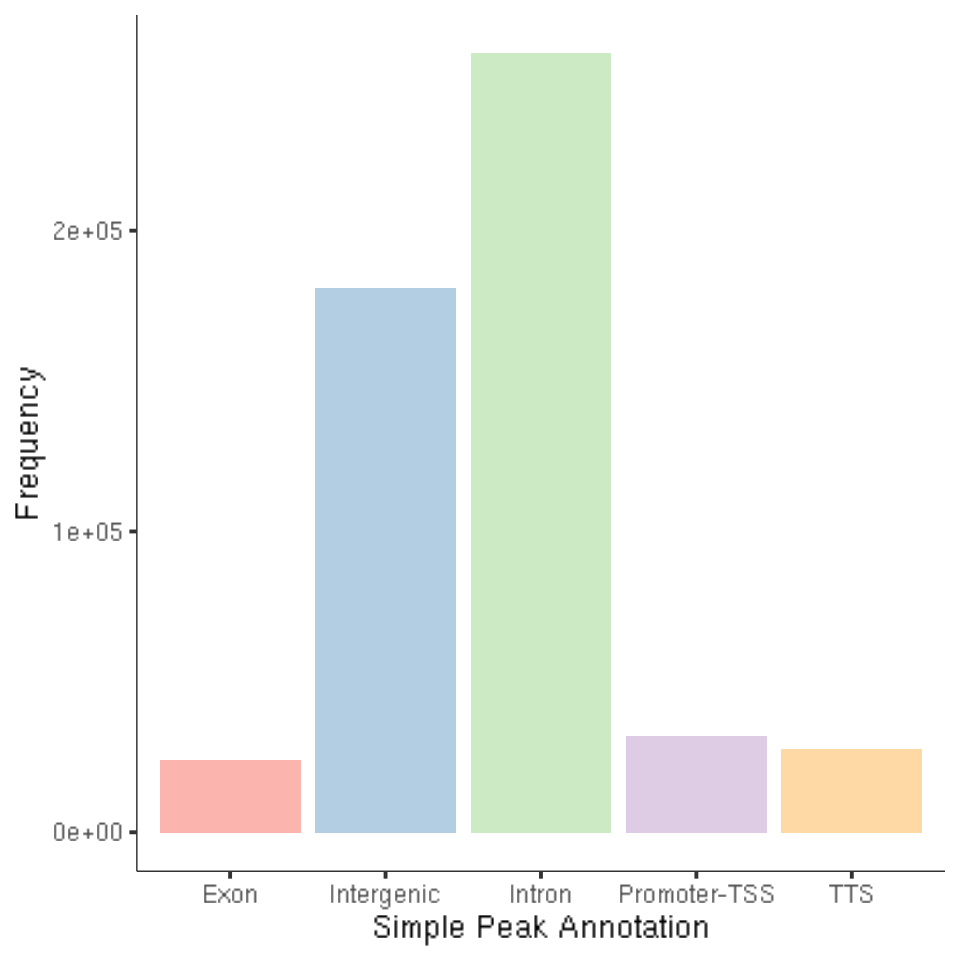

In [26]:
options(repr.plot.width=8, repr.plot.height=8)

ia.homer.annot %>%
    dplyr::filter(!is.na(Annotation)) %>%
    dplyr::mutate(Annotation.Simple=gsub(" \\(.*\\)", "", Annotation)) %>%
    dplyr::group_by(Annotation.Simple) %>%
    dplyr::summarize(Frequency=n()) %>%
    dplyr::mutate(Annotation.Simple=plyr::revalue(Annotation.Simple, c("exon"="Exon", "intron"="Intron", "promoter-TSS"="Promoter-TSS"))) %>%
    ggplot() +
    geom_bar(aes(x=Annotation.Simple, y=Frequency, fill=Annotation.Simple), stat="identity") +
    xlab("Simple Peak Annotation") +
    scale_fill_brewer(palette="Pastel1") + guides(fill="none") +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/homer_simple_peak_annotation.svg", width=8, height=8)

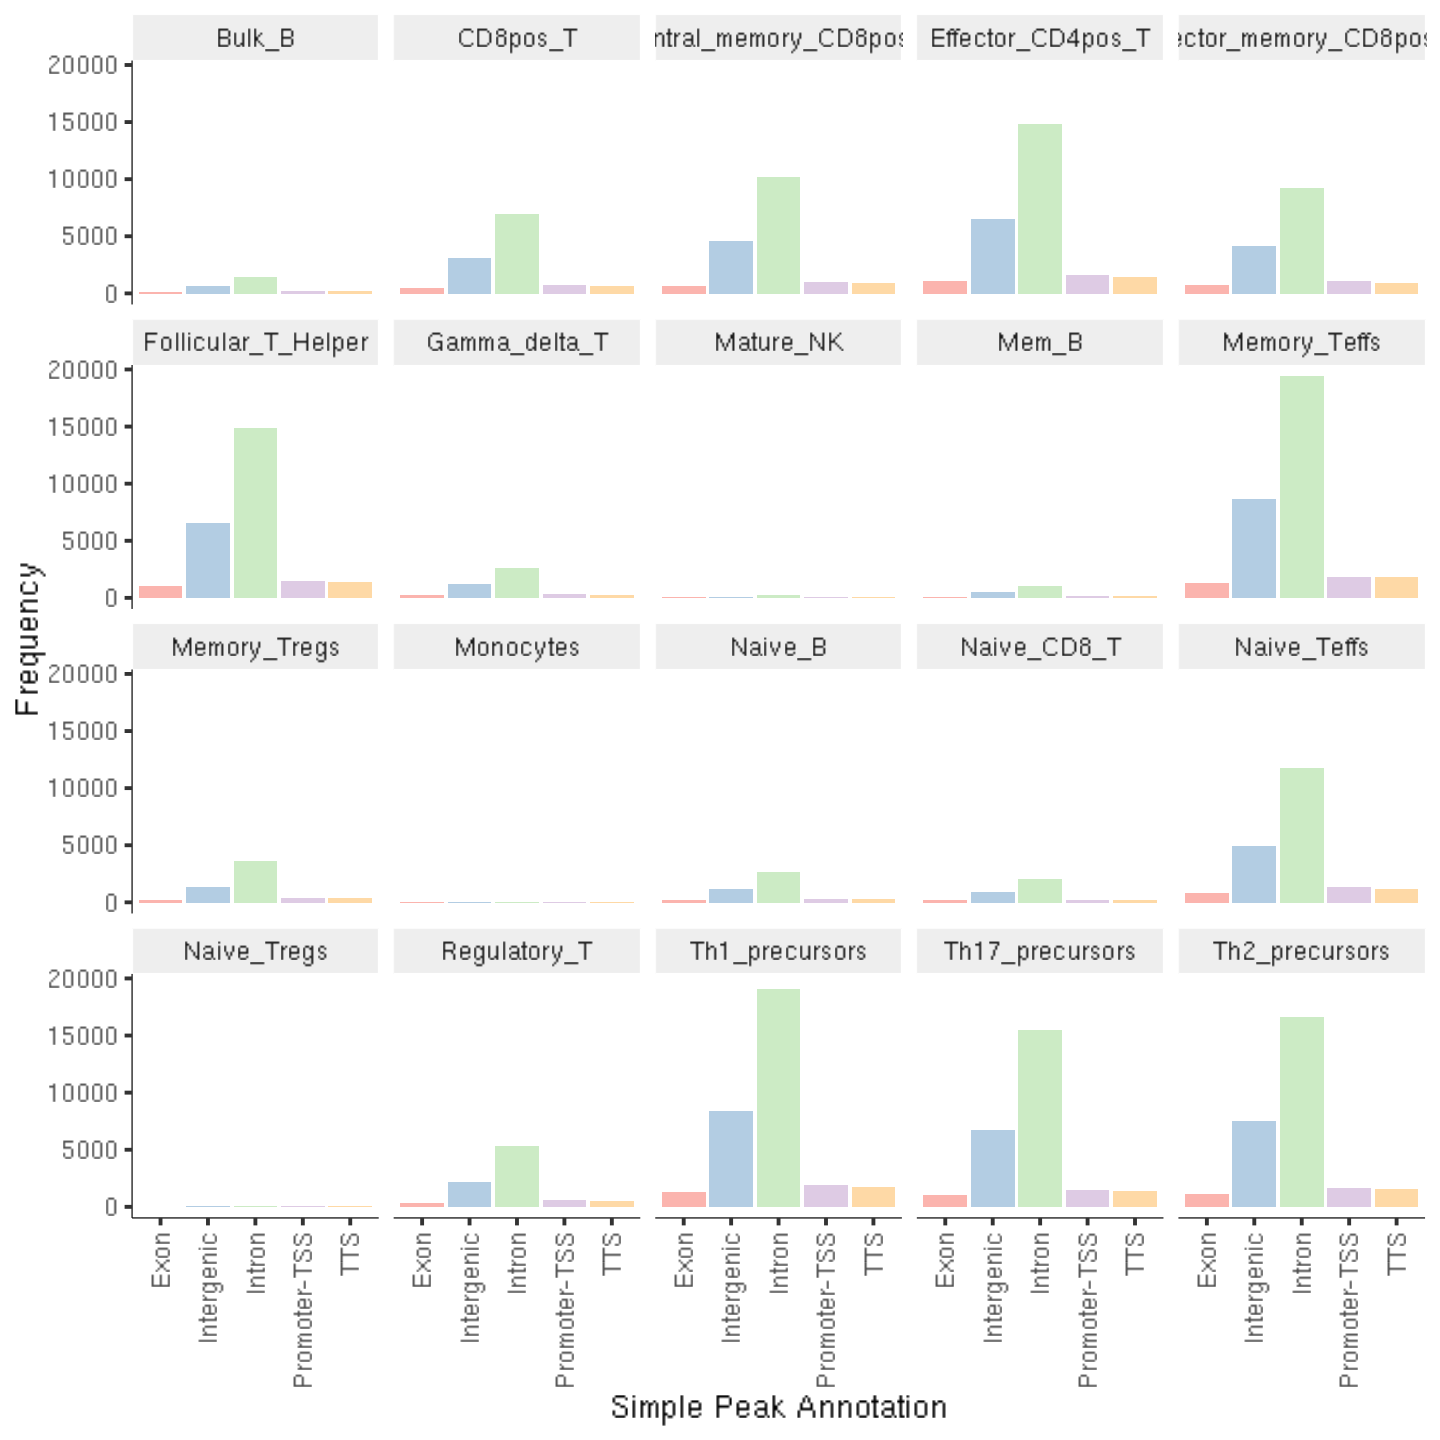

In [27]:
options(repr.plot.width=12, repr.plot.height=12)

ia.homer.annot %>%
    dplyr::filter(!is.na(Annotation)) %>%
    dplyr::mutate(Annotation.Simple=gsub(" \\(.*\\)", "", Annotation)) %>%
    merge(., ia.da.peaks, by.x="PeakID", by.y="Peak.ID") %>%
    dplyr::mutate(Annotation.Simple=plyr::revalue(Annotation.Simple, c("exon"="Exon", "intron"="Intron", "promoter-TSS"="Promoter-TSS"))) %>%
    ggplot() +
    geom_bar(aes(x=Annotation.Simple, fill=Annotation.Simple)) +
    xlab("Simple Peak Annotation") + ylab("Frequency") +
    scale_fill_brewer(palette="Pastel1") + guides(fill="none") +
    facet_wrap(Cell.Type~.) +
    ggplot_theme +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5))

ggsave("03_Functional_Interpretation/results/homer_simple_peak_annotation_cell_type.svg", width=12, height=12)

## Known Motifs in Neutrophils

SEA from the MEME suite checks for the enrichment of motifs in a set of sequences. I used all the transcription factors for vertebrates from JASPAR as input. I tested for motifs in both more accessible peaks and less accessible peaks. These could highlight transcription factors that drive downstream gene expression.

In [28]:
colors <- colorRampPalette(brewer.pal(9, "Reds"))(101)

plot.mtx <- rm.up.enriched.motifs %>%
    dplyr::mutate(Log2.Enr.Ratio=log2(ENR_RATIO)) %>%
    dplyr::filter(QVALUE < 0.001) %>%
    dplyr::filter(Log2.Enr.Ratio >= 1) %>%
    dplyr::select(ALT_ID, Treatment, Log2.Enr.Ratio) %>%
    tidyr::spread(ALT_ID, Log2.Enr.Ratio) %>%
    replace(is.na(.), 0)

rownames(plot.mtx) <- plot.mtx$Treatment
plot.mtx <- as.matrix(plot.mtx[,-1])

svg("03_Functional_Interpretation/results/enriched_motifs_more_accessible_rm.svg", width=18, height=3)
Heatmap(plot.mtx, col=colors, heatmap_legend_param=list(
    title=bquote("Log"[2]*"(Fold Enrichment)")
))
dev.off()

png 
  2

![](../results/enriched_motifs_more_accessible_rm.svg)

## Known Motifs in Immune Atlas

SEA from the MEME suite checks for the enrichment of motifs in a set of sequences. I used all the transcription factors for vertebrates from JASPAR as input. I tested for motifs in both more accessible peaks and less accessible peaks. These could highlight transcription factors that drive downstream gene expression.

In [31]:
colors <- colorRampPalette(brewer.pal(9, "Reds"))(101)

plot.mtx <- ia.up.enriched.motifs %>%
    dplyr::mutate(Log2.Enr.Ratio=log2(ENR_RATIO)) %>%
    dplyr::filter(QVALUE < 0.001) %>%
    dplyr::filter(Log2.Enr.Ratio >= 1) %>%
    dplyr::select(ALT_ID, Cell.Type, Log2.Enr.Ratio) %>%
    tidyr::spread(ALT_ID, Log2.Enr.Ratio) %>%
    replace(is.na(.), 0)

rownames(plot.mtx) <- plot.mtx$Cell.Type
plot.mtx <- as.matrix(plot.mtx[,-1])

svg("03_Functional_Interpretation/results/enriched_motifs_more_accessible_ia.svg", width=30, height=5.5)
Heatmap(plot.mtx, col=colors, heatmap_legend_param=list(
    title=bquote("Log"[2]*"(Fold Enrichment)")
))
dev.off()

png 
  2

![](../results/enriched_motifs_more_accessible_ia.svg)

In [32]:
colors <- colorRampPalette(brewer.pal(9, "Blues"))(101)

plot.mtx <- ia.down.enriched.motifs %>%
    dplyr::mutate(Log2.Enr.Ratio=log2(ENR_RATIO)) %>%
    dplyr::filter(QVALUE < 0.001) %>%
    dplyr::filter(Log2.Enr.Ratio >= 1) %>%
    dplyr::select(ALT_ID, Cell.Type, Log2.Enr.Ratio) %>%
    tidyr::spread(ALT_ID, Log2.Enr.Ratio) %>%
    replace(is.na(.), 0)

rownames(plot.mtx) <- plot.mtx$Cell.Type
plot.mtx <- as.matrix(plot.mtx[,-1])

svg("03_Functional_Interpretation/results/enriched_motifs_less_accessible_ia.svg", width=30, height=5.5)
Heatmap(plot.mtx, col=colors, heatmap_legend_param=list(
    title=bquote("Log"[2]*"(Fold Enrichment)")
))
dev.off()

png 
  2

![](../results/enriched_motifs_less_accessible_ia.svg)